<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/blob/main/tutorial-notebooks/4_BuildingComplexMeasurementLayouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Complex Measurement Layouts for Cognitive Benchmarks

**Lead Presenter**: Konstantinos Voudouris (Copyright (c), all rights reserved, 2024)

In this tutorial, we attempt to build a more complex measurement layout for some real agents. We incrementally build a measurement layout for studying the cognitive capability of object permanence in a complex three-dimensional environment. Finally, We evaluate some agents on a suite of tests.

*Feel free to save a copy of this notebook to your drive*

## Preamble

First, let's import the libraries and functions that we will need.

In [ ]:
import arviz as az
import gc
import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import random as rm
import seaborn as sns

from IPython.display import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from google.colab import files
from pymc import model
from xgboost import XGBRegressor
from xgboost import XGBClassifier

seed = 1997
rng = np.random.default_rng(seed) # set a seed for reproducibility

print(f"Running on PyMC v{pm.__version__}") #Note, colab imports an older version of PyMC by default. This won't cause problems for this tutorial, but may do if you use a different backend (e.g., gpu) and a jax/numpyro sampler. In which case, run `!pip install 'pymc>5.9' --quiet`

## Data

Now let's import and inspect the data. We have data to explore from RL agents as well as humans.

In [ ]:
agent_data_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/main/data/4_objectPermanenceDataAgents.csv'
opiaagets_dataset = pd.read_csv(agent_data_url)

human_data_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/main/data/4_objectPermanenceDataHuman.csv'
human_dataset = pd.read_csv(human_data_url)

Let's inspect the datasets. There are **4202 instances** and **16 metafeatures** for the performances of **4 agents**. There are **1608 instances** and **15 metafeatures** for human performances.

The metafeatures are as follows:
1. `basicTask` - is the task a basic task? Values (discrete, binary): `0` (No), `1` (Yes).
2. `pctbGridTask` - is the task a Primate Cognition Test Battery (PCTB) Grid task? Values (discrete binary): `0` (No), `1` (Yes).
3. `pctb3CupTask` - is the task a PCTB Cup task? Values (discrete binary): `0` (No), `1` (Yes).
3. `cvchickTask` - is the task a CV Chick task? Values (discrete binary): `0` (No), `1` (Yes).
3. `mainGoalSize` - what size is the goal in the task? Value range: `0.5` - `5.0`.
4. `lavaPresence` - does the instance contain lava? Values (discrete binary): `0` (No), `1` (Yes).
5. `goalLeft` - is there a goal placed to the left? Values (discrete binary): `0` (No), `1` (Yes).
5. `goalRight` - is there a goal placed to the right? Values (discrete binary): `0` (No), `1` (Yes).
5. `goalCentre` - is there a goal placed to ahead? Values (discrete binary): `0` (No), `1` (Yes).
5. `goalOccluded` - is the goal occluded when the agent starts the episode? Values (discrete binary): `0` (No), `1` (Yes).
6. `navigationDistanceGoal` - how far is the goal from the agent? This is calculated is the manhattan distance to the goal, avoiding any obstacles/pits. Value range: `9.0` - `118.0`.
6. `euclideanDistanceGoal` - how far is the goal from the agent? This is calculated is the euclidean distance to the goal, not avoiding any obstacles. Value range: `9.0` - `38.40`.
7. `navigationTurnsGoal` - how many right-angle turns would the agent take on the trajectory described by `navigationDistanceGoal`. Value range: `0.0` - `13.0`.
7. `navigationDistanceChoice` - how far is the choice point from the agent? This is calculated is the manhattan distance to the choice point, avoiding any obstacles/pits. Value range: `1.0` - `53.5`.
7. `navigationTurnsChoice` - how many right-angle turns would the agent take on the trajectory described by `navigationDistanceGoal`. Value range: `0.0` - `6.0`.
8. `numChoices` - how many choices does the agent have in the task? Value range: `1.0` - `12.0`.

The agents performed each of these tasks, and whether they obtained the goal (`1`) or not (`0`) and whether they picked the correct choice (`1`) or not (`0`) was recorded. The agents are as follows:
1. `Random_Agent` - An agent which randomly samples one of the 9 actions in the Animal-AI Environment (`no action`, `forwards`, `backwards`, `left rotate`, `right rotate`, `forwards left`, `forwards right`, `backwards left`, `backwards right`). It then takes that action for a number of steps sampled from $U(1, 20)$.
2. `Heuristic_Agent` - An agent that navigates towards rewarding items and away from punishing items, following a rigid rule.
3. `Dreamer` - A dreamer-v3 agent trained for 10M steps on the set of 2372 basic and practice tasks.
4. `PPO` - A PPO agent trained for 10M steps on the set of 2372 basic and practice tasks.
5. `Humans` - The combined performances of 30 humans playing a subset of the tasks that the agents were evaluated on.

In [ ]:
opiaagets_dataset.head()

In [ ]:
human_dataset.head()

Let's explore the aggregate performance of each kind of agent:

In [ ]:
print(f"The Random Agent passes {np.mean(opiaagets_dataset['Random_Agent_Success'])*100}% of tasks and makes the correct choice on {np.mean(opiaagets_dataset['Random_Agent_Choice'])*100}% of tasks.")
print(f"The PPO Agent passes {np.mean(opiaagets_dataset['PPO_Success'])*100}% of tasks and makes the correct choice on {np.mean(opiaagets_dataset['PPO_Choice'])*100}% of tasks.")
print(f"The Dreamer Agent passes {np.mean(opiaagets_dataset['Dreamer_Success'])*100}% of tasks and makes the correct choice on {np.mean(opiaagets_dataset['Dreamer_Choice'])*100}% of tasks.")
print(f"The Heuristic Agent passes {np.mean(opiaagets_dataset['Heuristic_Agent_Success'])*100}% of tasks and makes the correct choice on {np.mean(opiaagets_dataset['Heuristic_Agent_Choice'])*100}% of tasks.")
print(f"The Humans pass {np.mean(human_dataset['Human_Success'])*100}% of tasks and makes the correct choice on {np.mean(human_dataset['Human_Choice'])*100}% of tasks.")

Some initial expectations:

* We don't expect the Random Agent to have very good capabilities in general, because it is picking actions at random.
* We expect the Heuristic Agent to be good at things like navigation. It operates by turning until a green or yellow goal is directly ahead, and then moving forwards until it obtains it, regardless of how far away the goal is. However, we do not expect it to have object permanence, it has no form of memory.
* We expect humans to have generally good capabilities across the board.
* We do not know what to expect from PPO or Dreamer.

# Building A Complex Measurement Layout

We will incrementally build a complex measurement layout for studying object permanence.

**Feel free to skip to the** *Extending to the Multivariate Case* **section if you want to see the full implementation of the measurement layout.**


**Use the table of contents (on the left) to navigate around this notebook**



## Object Permanence

First, let's set up a simple measurement layout for the *Object Permanence* ability.

## An important link function

The leaf node of the measurement layout is success in this case, so we want to define it as a Bernoulli, taking a probability of success. Therefore, we'll need a logistic function. Because we are dealing with bounded capabilities, the logistic function a nice parameterisation would be for the probability of success on a task with a minimum demand for an agent with maximum ability to be 0.999. Alternatively, for an agent with minimum ability performing on a task with maximum demand, we would like a probability of success of 0.001. This is a nice parameterisation of the logistic function for our case of bounded capabilities.

In [2]:
def logistic999(x, min, max):    # This logistic function ensures that if x is at -(max-min), we get prob 0.001, and if x is at (max-min), we get prob 0.999
  x = x - min
  max = max - min
  x = 6.90675478 * x / max
  return 1 / (1 + np.exp(-x))

Try out the logistic here. Let's say you have an ability bounded between 0 and 100. An agent with maximum ability (100) performing on a task with the minimum demand (0) should pass with 0.999 probability. An agent with minimum ability (0) performing on a task with the maximum demand should pass with 0.001 probability. That means the minimum margin is $-(100-0)$ and the maximum margin is $(100-0)$.

In [ ]:
xpoints = np.linspace(-100, 100, 1000)
ypoints = logistic999(xpoints, 0, 100)
plt.plot(xpoints, ypoints)
plt.xlabel('Margin (Ability - Demand)')
plt.ylabel('Probability of Success')
plt.show()

(_Bonus_: Try different parameterisations of the logistic using the hidden code below, to see how it affects measurement layout behaviour. Reveal the hidden code below for a more general implementation.)

In [ ]:
# @title Bonus: A more general logistic function
def logistic(x, L=1, k=1, x_0=0): return (L / (1 + np.exp(-k * (x-x_0))))

## Our first capability

Let's build an initial measurement layout.

Let's start with object permanence. From cognitive science, we know that object permanence is harder when the object is occluded for longer and/or when there are more places it could be hidden. This gives us an overall *object permanence demand*.

How long the goal is occluded for in our tasks depends on the details of the agent. We need a task-specific demand, so a proxy we can use is `navigationDistanceGoal`, which serves as a proxy for time under occlusion. This is the shortest path to the goal avoiding any obstacles, taking only straight lines forwards and 90deg turns.

For the number of choices, we can use`numChoices`.

Finally, we are only interested in cases when the goal is occluded. This is encoded by the metafeature `goalOccluded`.

We can combine this in a very simple way:

$Demand_{OP} = Distance \times Choices \times Occluded$

The range of this demand defines the range of the latent ability. It ranges from 0 (whenever the goal is not occluded) to the maximum $Distance \times Choices$ in any task where the goal is occluded.

We don't know much about the shape of this ability for the individuals in question, so we can use the *Uniform* prior here.

Our margin will simply be:

$Margin_{OP} = Ability_{OP} - Demand_{OP}$

To convert this to a probability, we can use the `logistic999` function, or an alternative implementation of your choice.




In [ ]:
# @title Exercise 1: Object Permanence

"""
Fill in the gaps in the function below to set up the model.
"""
def setupOPModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max()) # the maximum distance x choices of any instance in the dataset

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility


  m = pm.Model()
  with m:

    # Define abilities and their priors

    ## SPECIFY THE OBJECT PERMANENCE ABILITY PRIOR HERE:

    objPermAbility =  ##### FILL IN HERE #####                   #we want to use the uniform prior bounded between minPermAbility and maxPermAbility

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values) #this is a proxy for how long the goal is occluded for.
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)

    # Margins

    ## SPECIFY THE MARGINS HERE

    objPermMargin =  ##### FILL IN HERE #####          # define the margin as the ability minus the combined
    objPermP =  ##### FILL IN HERE #####               # apply the logistic999 transformation with minPermAbility and maxPermAbility as the min and max

    taskSuccess = pm.Bernoulli("Success", objPermP, observed = results) #the transformed margin serves as the probability fed to the Bernoulli.

  return m, abilityMin, abilityMax

In [ ]:
# @title A Recommended Solution
def setupOPModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility


  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDist * opTest) * numChoices))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    taskSuccess = pm.Bernoulli("Success", objPermP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupOPModel(opiaagets_dataset, 'Random_Agent_Success')
gv = pm.model_graph.model_to_graphviz(m)
gv

Let's compare dreamer and humans on this capability

In [ ]:
agent = 'Dreamer_Success'

model_dreamer, abilityMin_dreamer, abilityMax_dreamer = setupOPModel(opiaagets_dataset, agent)
with model_dreamer:
  idata_dreamer = pm.sample(1000, target_accept=0.95, random_seed=rng)

human = 'Human_Success'

model_human, abilityMin_human, abilityMax_human = setupOPModel(human_dataset, human)
with model_human:
  idata_human = pm.sample(1000, target_accept=0.95, random_seed=rng)


ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["objPermAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated Object Permanence for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

We can also look at the summary statistics from the two measurement layouts:

In [ ]:
summary_dreamer = az.summary(idata_dreamer['posterior']['objPermAbility'])
summary_dreamer

In [ ]:
summary_human = az.summary(idata_human['posterior']['objPermAbility'])
summary_human

## Introducing Navigation

These tasks are fundamentally search tasks. The agent must navigate towards the reward. As such, an agent with object permanence but poor at navigation may fail many of these tasks. Moreover, an agent without object permanence, but that is good at navigating, may accidentally obtain the reward on occasion.

The simplest way to frame this is to say that navigation and object permanence are non-compensatory - being good at navigation does not compensate for being bad at object permanence, and vice versa. For the purposes of this tutorial, we can proceed with this formulation, although it may be more accurate to implement an asymmetric compensatory relationship between these too (since, arguably, navigation is more compensatory for object permanence than vice versa).

Navigation demands can be implemented in terms of how far away the goal is along with the circuitousness of the route. We can define this as the product of distance and number of turns.

$Demand_{Nav} = Distance \times Turns$

Let's extend the measurement layout to include navigation. Let's again define the combined object permanence demand as the distance to the goal (`minDistToGoal`) multiplied by the number of choice (`numChoices`) multiplied by whether or not a goal is present (`goalOccluded`). Let's define the navigation demand as the distance to the goal (`minDistToGoal`) multiplied by the number of turns it takes to get there, avoiding obstacles (`minNumTurnsGoal`).

In [ ]:
# @title Exercise 2: Navigation

"""
Fill in the gaps in the function below to set up the model.
"""
def setupOPNavModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min()) # the minimum (distance x turns) of any instance

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max()) # the maximum (distance x turns) of any instance

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility


  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)



    ## SPECIFY THE Navigation ABILITY (navAbility) PRIOR HERE:

    navAbility =  ##### FILL IN HERE #####        # Again the uniform seems most suitable here.







    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDist * opTest) * numChoices))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))






    ## SPECIFY THE MARGINS HERE


    navP = ##### FILL IN HERE #####    # We want the same sort of margin as above for navigation.

    # Define final margin with non-compensatory interaction (as a product of navP and objPermP)

    finalP = ##### FILL IN HERE #####








    taskSuccess = pm.Bernoulli("Success", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
# @title  A Recommended Solution
def setupOPNavModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility


  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDist* opTest) * numChoices ))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    navP = pm.Deterministic("navP", logistic999(navAbility - (goalDist * numTurnsGoal), min = minNavAbility, max = maxNavAbility))

    # Define final margin with non-compensatory interaction

    finalP = pm.Deterministic("finalP", (objPermP * navP))

    taskSuccess = pm.Bernoulli("Success", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupOPNavModel(opiaagets_dataset, 'Random_Agent_Success')
gv = pm.model_graph.model_to_graphviz(m)
gv

Let's compare dreamer and humans on this capability:

In [ ]:
agent = 'Dreamer_Success'

model_dreamer, abilityMin_dreamer, abilityMax_dreamer = setupOPNavModel(opiaagets_dataset, agent)
with model_dreamer:
  idata_dreamer = pm.sample(1000, target_accept=0.95, random_seed=rng)

human = 'Human_Success'

model_human, abilityMin_human, abilityMax_human = setupOPNavModel(human_dataset, human)
with model_human:
  idata_human = pm.sample(1000, target_accept=0.95, random_seed=rng)


ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["objPermAbility", "navAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated OP and Nav for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

And here are the summaries:

In [ ]:
summary_dreamer = az.summary(idata_dreamer['posterior'][['objPermAbility', 'navAbility']])
summary_dreamer

In [ ]:
summary_human = az.summary(idata_human['posterior'][['objPermAbility', 'navAbility']])
summary_human

## Introducing Binary Capabilities: Lava

Another feature of the benchmark that ought to affect behaviour is the presence of lava. In many tasks, particularly the CV Chick tasks and some of the 3 Cup tasks have lava in them. Let's include lava.



First, we have a new metafeature for lava, let's incorporate that into the measurement layout. To do so, we will make use of the Beta prior because the `lavaPresence` is a binary metafeature. We also need to make use of a special margin for these capabilities. Here, if the binary feature is 0, then the margin represents p(success) = 1. If the binary feature is 1, then p(success) = ability.

In [ ]:
def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

In [ ]:
# @title Exercise 3: Lava

"""
Fill in the gaps in the function below to set up the model.
"""

def setupOPNavLavaModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)






    ## SPECIFY THE MARGINS HERE

    lavaAbility =   ##### FILL IN HERE #####                   # The Beta prior (pm.Beta) is appropriate for binary variables like this one. With parameters (1, 1) it serves as an uninformative prior.









    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDist * opTest) * numChoices ))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    navP = pm.Deterministic("navP", logistic999((navAbility - (goalDist * numTurnsGoal)), min = minNavAbility, max = maxNavAbility))








    ## SPECIFY THE MARGINS HERE

    ## For this binary feature, we can use the SimplePrMargin function, which returns a probability

    lavaP =   ##### FILL IN HERE #####

    # Define final margin with non-compensatory interaction (as a product of the P values)

    finalP =    ##### FILL IN HERE #####








    taskSuccess = pm.Bernoulli("ObservedPerformance", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
# @title A Recommended Solution
def setupOPNavLavaModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    lavaAbility = pm.Beta("lavaAbility", 1, 1)

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistance", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDist * opTest) * numChoices ))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    navP = pm.Deterministic("navP", logistic999((navAbility - (goalDist * numTurnsGoal)), min = minNavAbility, max = maxNavAbility))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))


    # Define final margin with non-compensatory interaction

    finalP = pm.Deterministic("finalP", (objPermP * navP * lavaP))

    taskSuccess = pm.Bernoulli("Success", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupOPNavLavaModel(opiaagets_dataset, 'Random_Agent_Success')
gv = pm.model_graph.model_to_graphviz(m)
gv

Let's look at the capabilities of these agents

In [ ]:
agent = 'Dreamer_Success'

model_dreamer, abilityMin_dreamer, abilityMax_dreamer = setupOPNavLavaModel(opiaagets_dataset, agent)
with model_dreamer:
  idata_dreamer = pm.sample(1000, target_accept=0.95, random_seed=rng)

human = 'Human_Success'

model_human, abilityMin_human, abilityMax_human = setupOPNavLavaModel(human_dataset, human)
with model_human:
  idata_human = pm.sample(1000, target_accept=0.95, random_seed=rng)


ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["objPermAbility", "navAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated OP and Nav for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["lavaAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated lava ability for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

Let's also look at the summaries

*Note, training with more samples and with more chains might lead to better estimates*

In [ ]:
summary_dreamer = az.summary(idata_dreamer['posterior'][['objPermAbility', 'navAbility', 'lavaAbility']])
summary_dreamer

In [ ]:
summary_human = az.summary(idata_human['posterior'][['objPermAbility', 'navAbility', 'lavaAbility']])
summary_human

These tasks are heavily affected by what the agent can and cannot see. Depending on the input, agents can struggle to observe smaller, more distant goals. So let's introduce a visual acuity ability.

## Introducing Visual Acuity

As in the previous tutorial, we define visual acuity in terms of the size and distance of the goal (when it is visible) from the agent at the start of the episode. We can use `mainGoalSize` for the size metafeature and `euclideanDistanceGoal` for the distance metafeature (since we don't care if there are obstacles in the way, like we do with navigation).

The demand is described as:

$Demand_{acuity} = \frac{Distance}{Size}$

To generate the margin, we can do the following (as in the previous session):

$Margin_{acuity} = $ `logistic999` $(log(Ability_{acuity}) - log(Demand_{acuity}))$

In [ ]:
# @title Exercise 4: Visual Acuity

"""
Fill in the gaps in the function below to set up the model.
"""

def setupOPNavLavaVisualModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())
  minVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())
  maxVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1

  abilityMin["visualAcuityAbility"] = minVAcuityAbility
  abilityMax["visualAcuityAbility"] = maxVAcuityAbility

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    lavaAbility = pm.Beta("lavaAbility", 1, 1)






    ## SPECIFY THE visual acuity ABILITY (navAbility) PRIOR HERE:

    vAcuityAbility =   ##### FILL IN HERE #####   # A uniform prior bounded between minVAcuityAbility and maxVAcuityAbility could work here.










    # Define environment variables as MutableData

    goalDistNavigation = pm.MutableData("goalDistanceNavigation", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)
    goalSize = pm.MutableData("goalSize", data["mainGoalSize"].values)
    goalDistanceVisual  = pm.MutableData("goalDistanceVisual", data["euclideanDistanceGoal"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDistNavigation* opTest) * numChoices))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    navP = pm.Deterministic("navP", logistic999((navAbility - (goalDistNavigation * numTurnsGoal)), min = minNavAbility, max = maxNavAbility))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))






    ## SPECIFY THE MARGINS HERE

    visualAcuityP =  ##### FILL IN HERE #####               # remember to apply the log transform (np.log()) to the ability and the demand, and then use logistic999

    # Define final margin with non-compensatory interaction (as a product of the P values)

    finalP =     ##### FILL IN HERE #####










    taskSuccess = pm.Bernoulli("Success", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
# @title A Recommended Solution
def setupOPNavLavaVisualModel(data, agent_col_name: str):

  # get results column
  results = data[agent_col_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minPermAbility = 0
  minNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())
  minVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())
  maxVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1

  abilityMin["visualAcuityAbility"] = minVAcuityAbility
  abilityMax["visualAcuityAbility"] = maxVAcuityAbility

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    lavaAbility = pm.Beta("lavaAbility", 1, 1)

    vAcuityAbility = pm.Uniform("visualAcuityAbility", minVAcuityAbility, maxVAcuityAbility)

    # Define environment variables as MutableData

    goalDistNavigation = pm.MutableData("goalDistanceNavigation", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)
    goalSize = pm.MutableData("goalSize", data["mainGoalSize"].values)
    goalDistanceVisual  = pm.MutableData("goalDistanceVisual", data["euclideanDistanceGoal"].values)

    # Margins

    objPermMargin = (objPermAbility - ((goalDistNavigation* opTest) * numChoices))
    objPermP = pm.Deterministic("objPermP", logistic999(objPermMargin, min = minPermAbility, max = maxPermAbility))

    navP = pm.Deterministic("navP", logistic999((navAbility - (goalDistNavigation * numTurnsGoal)), min = minNavAbility, max = maxNavAbility))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))

    visualAcuityP = pm.Deterministic("visualAcuityP", logistic999((np.log(vAcuityAbility) - np.log(goalDistanceVisual/goalSize)), min = minVAcuityAbility, max = maxVAcuityAbility))

    # Define final margin with non-compensatory interaction

    finalP = pm.Deterministic("finalP", (objPermP * navP * lavaP * visualAcuityP))

    taskSuccess = pm.Bernoulli("Success", finalP, observed = results)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupOPNavLavaVisualModel(opiaagets_dataset, 'Random_Agent_Success')
gv = pm.model_graph.model_to_graphviz(m)
gv

Let's compare dreamer and humans on this capability:

In [ ]:
agent = 'Dreamer_Success'

model_dreamer, abilityMin_dreamer, abilityMax_dreamer = setupOPNavLavaVisualModel(opiaagets_dataset, agent)
with model_dreamer:
  idata_dreamer = pm.sample(1000, target_accept=0.95, random_seed=rng)

human = 'Human_Success'

model_human, abilityMin_human, abilityMax_human = setupOPNavLavaVisualModel(human_dataset, human)
with model_human:
  idata_human = pm.sample(1000, target_accept=0.95, random_seed=rng)


ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["objPermAbility", "navAbility", "visualAcuityAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated OP, Nav, and Visual for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

ax = az.plot_forest(
    [idata_dreamer, idata_human],
    model_names=["Dreamer", "Human"],
    var_names=["lavaAbility"],
    figsize=(11.5, 5),
)
ax[0].set_title("The estimated lava ability for 2 agents.\nNote that there are two estimates for each agent. One for each chain.")
plt.show()

And let's look at the summaries:

In [ ]:
summary_dreamer = az.summary(idata_dreamer['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility']])
summary_dreamer

In [ ]:
summary_human = az.summary(idata_human['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility']])
summary_human

<a id="end"></a>

# Extending To The Multivariate Case

The results contain another response variable: whether the agent chose the correct choice or not. In tasks where there was no choice to be made, the correct choice is simply whether they succeeded on the task.

Now let's introduce the second response variable, `correctChoice`, and the corresponding metafeatures.


There is the navigation demand of navigating to the goal, which is quite high in both the PCTB and CV Chick tasks. However, there is also the navigation demand of navigating to the choice point, which is high for the PCTB tasks (equivalent to navigating to the goal), but low for the CV Chick tasks (they only need to navigate to the end of the ramp).



Find a possible implementation below:

Feel free to play around with how everything is connected:

In [ ]:
def setupMultivariateModel(data, agent_success_name: str, agent_choice_name: str):


  ## Prepare for the model:


  # get results column
  successes = data[agent_success_name]
  choices = data[agent_choice_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minSuccessNav = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())
  minChoiceNav = ((data["navigationDistanceChoice"] * data["navigationTurnsChoice"]).min())

  maxSuccessNav = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())
  maxChoiceNav = ((data["navigationDistanceChoice"] * data["navigationTurnsChoice"]).max())

  minPermAbility = 0
  minVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).max())

  minNavAbility = min([minSuccessNav, minChoiceNav])
  maxNavAbility = max([maxSuccessNav, maxChoiceNav])

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["visualAcuityAbility"] = minVAcuityAbility
  abilityMax["visualAcuityAbility"] = maxVAcuityAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1


  ## Define the Model:

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    vAcuityAbility = pm.Uniform("visualAcuityAbility", minVAcuityAbility, maxVAcuityAbility)

    lavaAbility = pm.Beta("lavaAbility", 1, 1)

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistanceNavigation", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    goalSize = pm.MutableData("goalSize", data["mainGoalSize"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)
    goalDistanceVisual  = pm.MutableData("goalDistanceVisual", data["euclideanDistanceGoal"].values)

    choiceDist = pm.MutableData("goalDistanceChoice", data["navigationDistanceGoal"].values)
    numTurnsChoice = pm.MutableData("navigationTurnsChoice", data["navigationTurnsChoice"].values)

    # Margins

    objPermMarginSuccess = (objPermAbility - ((goalDist * opTest) * numChoices))
    objPermSuccessP = pm.Deterministic("objPermSuccessP", logistic999(objPermMarginSuccess, min = minPermAbility, max = maxPermAbility))

    objPermMarginChoice = (objPermAbility - ((choiceDist * opTest) * numChoices ))
    objPermChoiceP = pm.Deterministic("objPermChoiceP", logistic999(objPermMarginChoice, min = minPermAbility, max = maxPermAbility))

    lavaP = pm.Deterministic("lavaP", logistic999(lavaAbility - lavaPresence, min = 0, max = 1))

    navSuccessP = pm.Deterministic("navSuccessP", logistic999((navAbility - (goalDist * numTurnsGoal)), min = minNavAbility, max = maxNavAbility) * lavaP)
    navChoiceP = pm.Deterministic("navChoiceP", logistic999((navAbility - (choiceDist * numTurnsChoice)), min = minNavAbility, max = maxNavAbility))

    visualAcuityP = pm.Deterministic("visualAcuityP", logistic999((np.log(vAcuityAbility) - np.log(goalDistanceVisual/goalSize)), min = minVAcuityAbility, max = maxVAcuityAbility))

    # Define final margin with non-compensatory interaction (as a product of the P values)

    choiceP = pm.Deterministic("choiceP", (navChoiceP * objPermChoiceP * visualAcuityP)) # visual acuity is relevant to making a choice, rather than success on the task
    successP = pm.Deterministic("successP", (navSuccessP * objPermSuccessP))

    taskSuccess = pm.Bernoulli("Success", successP, observed=successes)
    taskChoice = pm.Bernoulli("CorrectChoice", choiceP, observed=choices)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupMultivariateModel(opiaagets_dataset, 'Random_Agent_Success', 'Random_Agent_Choice')
gv = pm.model_graph.model_to_graphviz(m)
gv

Finally, we can add three more capabilities corresponding to the binary metafeatures for whether there is a goal left, centre, or ahead of the agent.

In [ ]:
def setupComplexMultivariateModel(data, agent_success_name: str, agent_choice_name: str):

  ## Prepare for the model:

  # get results column
  successes = data[agent_success_name]
  choices = data[agent_choice_name]

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minSuccessNav = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).min())
  minChoiceNav = ((data["navigationDistanceChoice"] * data["navigationTurnsChoice"]).min())

  maxSuccessNav = ((data["navigationDistanceGoal"] * data["navigationTurnsGoal"]).max())
  maxChoiceNav = ((data["navigationDistanceChoice"] * data["navigationTurnsChoice"]).max())

  minPermAbility = 0
  minNavAbility = min([minSuccessNav, minChoiceNav])
  minVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).min())

  maxPermAbility = ((data["navigationDistanceGoal"] * data["numChoices"]).max())
  maxNavAbility = max([maxSuccessNav, maxChoiceNav])
  maxVAcuityAbility = ((data["euclideanDistanceGoal"]/data["mainGoalSize"]).max())

  abilityMin["objPermAbility"] = minPermAbility
  abilityMax["objPermAbility"] = maxPermAbility

  abilityMin["navAbility"] = minNavAbility
  abilityMax["navAbility"] = maxNavAbility

  abilityMin["visualAcuityAbility"] = minVAcuityAbility
  abilityMax["visualAcuityAbility"] = maxVAcuityAbility

  abilityMin["lavaAbility"] = 0
  abilityMax["lavaAbility"] = 1

  abilityMin["rightAbility"] = 0
  abilityMax["rightAbility"] = 1

  abilityMin["leftAbility"] = 0
  abilityMax["leftAbility"] = 1

  abilityMin["aheadAbility"] = 0
  abilityMax["aheadAbility"] = 1


  ## Define the model:

  m = pm.Model()
  with m:

    # Define abilities and their priors

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)

    navAbility = pm.Uniform("navAbility", minNavAbility, maxNavAbility)

    vAcuityAbility = pm.Uniform("visualAcuityAbility", minVAcuityAbility, maxVAcuityAbility)

    lavaAbility = pm.Beta("lavaAbility", 1, 1)

    rightAbility = pm.Beta("rightAbility", 1, 1)

    centreAbility = pm.Beta("centreAbility", 1, 1)

    leftAbility = pm.Beta("leftAbility", 1, 1)

    # Define environment variables as MutableData

    goalDist = pm.MutableData("goalDistanceNavigation", data["navigationDistanceGoal"].values)
    numChoices = pm.MutableData("numChoices", data["numChoices"].values)
    opTest = pm.MutableData("goalOccluded", data["goalOccluded"].values)
    numTurnsGoal = pm.MutableData("navigationTurnsGoal", data["navigationTurnsGoal"].values)
    goalSize = pm.MutableData("goalSize", data["mainGoalSize"].values)
    lavaPresence = pm.MutableData("lavaPresence", data["lavaPresence"].values)
    goalDistanceVisual  = pm.MutableData("goalDistanceVisual", data["euclideanDistanceGoal"].values)

    choiceDist = pm.MutableData("goalDistanceChoice", data["navigationDistanceGoal"].values)
    numTurnsChoice = pm.MutableData("navigationTurnsChoice", data["navigationTurnsChoice"].values)

    goalRight = pm.MutableData("goalRight", data["goalRight"].values)
    goalCentre = pm.MutableData("goalCentre", data["goalCentre"].values)
    goalLeft = pm.MutableData("goalLeft", data["goalLeft"].values)

    # Margins

    objPermMarginSuccess = (objPermAbility - ((goalDist * opTest) * numChoices))
    objPermSuccessP = pm.Deterministic("objPermSuccessP", logistic999(objPermMarginSuccess, min = minPermAbility, max = maxPermAbility))

    objPermMarginChoice = (objPermAbility - ((choiceDist * opTest) * numChoices ))
    objPermChoiceP = pm.Deterministic("objPermChoiceP", logistic999(objPermMarginChoice, min = minPermAbility, max = maxPermAbility))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))

    rightP = pm.Deterministic("rightP", SimplePrMargin(rightAbility, goalRight))
    centreP = pm.Deterministic("centreP", SimplePrMargin(centreAbility, goalCentre))
    leftP = pm.Deterministic("leftP", SimplePrMargin(leftAbility, goalLeft))

    navSuccessP = pm.Deterministic("navSuccessP", logistic999((navAbility - (goalDist * numTurnsGoal)), min = minNavAbility, max = maxNavAbility) * lavaP)
    navChoiceP = pm.Deterministic("navChoiceP", logistic999((navAbility - (choiceDist * numTurnsChoice)), min = minNavAbility, max = maxNavAbility) * rightP * centreP * leftP)

    visualAcuityP = pm.Deterministic("visualAcuityP", logistic999((np.log(vAcuityAbility) - np.log(goalDistanceVisual/goalSize)), min = minVAcuityAbility, max = maxVAcuityAbility))

    # Define final margin with non-compensatory interaction (as a product of the P values)

    choiceP = pm.Deterministic("choiceP", (navChoiceP * objPermChoiceP * visualAcuityP))
    successP = pm.Deterministic("successP", (navSuccessP * objPermSuccessP))

    taskSuccess = pm.Bernoulli("Success", successP, observed=successes)
    taskChoice = pm.Bernoulli("CorrectChoice", choiceP, observed=choices)

  return m, abilityMin, abilityMax

In [ ]:
m, abilityMin, abilityMax = setupComplexMultivariateModel(opiaagets_dataset, 'Random_Agent_Success', 'Random_Agent_Choice')
gv = pm.model_graph.model_to_graphviz(m)
gv

# Prediction On Unseen Data


With this more complex measurement layout, let's see how predictive it is.

First, we define some specialist Brier Score functions for working with the multivariate measurement layout:

In [ ]:
# A function for making predictions based on a fitted measurement layout with fixed metafeatures and multiple outputs.
def predict(m, agentData, dfTest, agent_success, agent_choice):
  """Generates the probability of success on a set of new instances

    Args:
        m: the pymc model
        agentData: the inference data from training
        dfTest: the held-out test data
        agent_success: the column name for the success results of each agent
        agent_choice: the column name for the choice results of each agent

    Returns:
        predictionsSuccessInstance: the probabilities of success on each instance
        predictionsChoiceInstance: the probabilities of correct choic on each instance
        successes: the vector of successes on the test set
        choices: the vector of choices on the test set
  """
  with m:
    # set the data for prediction
    pm.set_data({"lavaPresence": dfTest["lavaPresence"]})
    pm.set_data({"numChoices": dfTest["numChoices"]})
    pm.set_data({"navigationTurnsGoal": dfTest["navigationTurnsGoal"]})
    pm.set_data({"goalDistanceNavigation": dfTest["navigationDistanceGoal"]})
    pm.set_data({"navigationTurnsChoice": dfTest["navigationTurnsChoice"]})
    pm.set_data({"goalDistanceChoice": dfTest["navigationDistanceChoice"]})
    pm.set_data({"goalSize": dfTest["mainGoalSize"]})
    pm.set_data({"goalRight": dfTest["goalRight"]})
    pm.set_data({"goalCentre": dfTest["goalCentre"]})
    pm.set_data({"goalLeft": dfTest["goalLeft"]})
    pm.set_data({"goalOccluded": dfTest["goalOccluded"]})
    pm.set_data({"goalDistanceVisual": dfTest["euclideanDistanceGoal"]})

    predictions = pm.sample_posterior_predictive(agentData, var_names=["choiceP", "successP"], return_inferencedata=False, predictions=True, extend_inferencedata=False)
    predictionSuccessChainRuns = predictions["successP"][:,:,0:len(dfTest)]
    predictionsSuccessInstance = np.mean(predictionSuccessChainRuns, (0,1))
    predictionChoiceChainRuns = predictions["choiceP"][:,:,0:len(dfTest)]
    predictionsChoiceInstance = np.mean(predictionChoiceChainRuns, (0,1))

    successes = dfTest[agent_success].to_numpy()
    choices = dfTest[agent_choice].to_numpy()

    return predictionsSuccessInstance, predictionsChoiceInstance, successes, choices


def brierScore(preds, outs):
  """
  The simple Brier Score using probabilities from the model (preds) and the actual outcomes (outs)
  """
  return 1/len(preds) * sum( (preds-outs)**2 )

Split the data into train and test:

In [ ]:
train_data, test_data = train_test_split(opiaagets_dataset, test_size=0.2, random_state = seed)
human_train_data, human_test_data = train_test_split(human_dataset, test_size=0.2, random_state = seed)

In [ ]:
# @title RL Agent

# choose between PPO, Dreamer, Random, and Heuristic and see how predictive they are compared to the aggregate model

agent_name = "Dreamer" #"PPO" # "Heuristic Agent" # "Random Agent"
success, choice = 'Dreamer_Success', 'Dreamer_Choice'
#success, choice = 'PPO_Success', 'PPO_Choice'
#success, choice = 'Heuristic_Agent_Success', 'Heuristic_Agent_Choice'
#success, choice = 'Random_Agent_Success', 'Random_Agent_Choice'

model, abilityMin, abilityMax = setupComplexMultivariateModel(train_data, success, choice)

with model:
  idata = pm.sample(1000, tune = 500, target_accept=0.95, random_seed=rng) # use a shorter tune phase so that it runs faster. Feel free to play with the sample sizes and the number of tuning draws to see how it affects fitting

predictionsSuccessInstance, predictionsChoiceInstance, successes, choices = predict(model, idata, test_data, success, choice)

brierScoreSuccess_model = brierScore(predictionsSuccessInstance, test_data[success])
brierScoreSuccess_agg = brierScore(np.repeat(np.mean(train_data[success]), len(test_data[success])), test_data[success])

brierScoreChoice_model = brierScore(predictionsChoiceInstance, test_data[choice])
brierScoreChoice_agg = brierScore(np.repeat(np.mean(train_data[choice]), len(test_data[choice])), test_data[choice])

better_fit_success = "measurement layout" if brierScoreSuccess_model < brierScoreSuccess_agg else "aggregate model"
better_fit_choice = "measurement layout" if brierScoreChoice_model < brierScoreChoice_agg else "aggregate model"

print(f"The Brier Score for Success for the measurement layout for {agent_name} is {brierScoreSuccess_model}. The Brier Score for Success for the aggregate model is {brierScoreSuccess_agg}.")
print(f"The {better_fit_success} is more predictive for success.")

print(f"The Brier Score for Choice for the measurement layout for {agent_name} is {brierScoreChoice_model}. The Brier Score for Choice for the aggregate model is {brierScoreChoice_agg}.")
print(f"The {better_fit_choice} is more predictive for choice.")

In [ ]:
# @title Humans

# try it out with the data from humans!

agent_name = "Humans"

success, choice = 'Human_Success', 'Human_Choice'

model, abilityMin, abilityMax = setupComplexMultivariateModel(human_train_data, success, choice)

with model:
  idata = pm.sample(1000, tune = 500, target_accept=0.95, random_seed=rng) # use a shorter tune phase so that it runs faster. Feel free to play with the sample sizes and the number of tuning draws to see how it affects fitting

predictionsSuccessInstance, predictionsChoiceInstance, successes, choices = predict(model, idata, human_test_data, success, choice)

brierScoreSuccess_model = brierScore(predictionsSuccessInstance, human_test_data[success])
brierScoreSuccess_agg = brierScore(np.repeat(np.mean(human_train_data[success]), len(human_test_data[success])), human_test_data[success])

brierScoreChoice_model = brierScore(predictionsChoiceInstance, human_test_data[choice])
brierScoreChoice_agg = brierScore(np.repeat(np.mean(human_train_data[choice]), len(human_test_data[choice])), human_test_data[choice])

better_fit_success = "measurement layout" if brierScoreSuccess_model < brierScoreSuccess_agg else "aggregate model"
better_fit_choice = "measurement layout" if brierScoreChoice_model < brierScoreChoice_agg else "aggregate model"

print(f"The Brier Score for Success for the measurement layout for {agent_name} is {brierScoreSuccess_model}. The Brier Score for Success for the aggregate model is {brierScoreSuccess_agg}.")
print(f"The {better_fit_success} is more predictive for success.")

print(f"The Brier Score for Choice for the measurement layout for {agent_name} is {brierScoreChoice_model}. The Brier Score for Choice for the aggregate model is {brierScoreChoice_agg}.")
print(f"The {better_fit_choice} is more predictive for choice.")

**Note, with humans and the Random Agents, the Brier Scores might be quite high for the measurement layout.** Try ablating the measurement layout to get better prediction (*hint*: humans played instances with goals of constant size, and the random agents receive no visual input, so it might have something to do with the visual acuity capability...)

# Explore the Capabilities of Each Agent

With this more complex model, you can explore the capabilities of the Random Agent, the Heuristic Agent, PPO, Dreamer, and even humans!

This has already been run and the results are presented below. If you want to rerun these agents, reveal the code block below.



In [ ]:
# @title
model_dreamer, abilityMin_dreamer, abilityMax_dreamer = setupComplexMultivariateModel(opiaagets_dataset, 'Dreamer_Success', 'Dreamer_Choice')
with model_dreamer:
  idata_dreamer = pm.sample(1000, target_accept=0.95, random_seed=rng)

model_ppo, abilityMin_ppo, abilityMax_ppo = setupComplexMultivariateModel(opiaagets_dataset, 'PPO_Success', 'PPO_Choice')
with model_ppo:
  idata_ppo = pm.sample(1000, target_accept=0.95, random_seed=rng)

model_random, abilityMin_random, abilityMax_random = setupComplexMultivariateModel(opiaagets_dataset, 'Random_Agent_Success', 'Random_Agent_Choice')
with model_random:
  idata_random = pm.sample(1000, target_accept=0.95, random_seed=rng)

model_heuristic, abilityMin_heuristic, abilityMax_heuristic = setupComplexMultivariateModel(opiaagets_dataset, 'Heuristic_Agent_Success', 'Heuristic_Agent_Choice')
with model_heuristic:
  idata_heuristic = pm.sample(1000, target_accept=0.95, random_seed=rng)

model_human, abilityMin_human, abilityMax_human = setupComplexMultivariateModel(human_dataset, 'Human_Success', 'Human_Choice')
with model_human:
  idata_human = pm.sample(1000, target_accept=0.95, random_seed=rng)


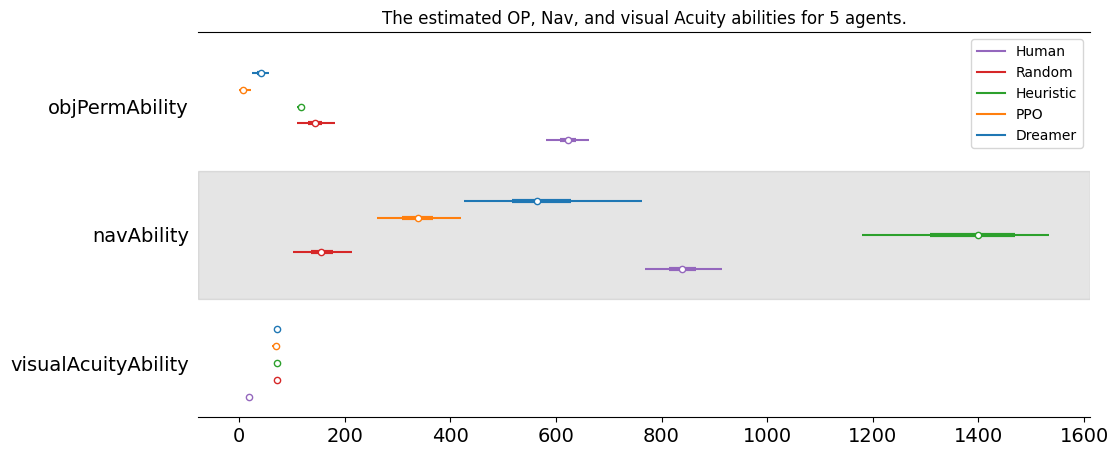

In [ ]:
# @title Results

ax = az.plot_forest(
    [idata_dreamer, idata_ppo, idata_heuristic, idata_random, idata_human],
    model_names=["Dreamer", "PPO", "Heuristic", "Random", "Human"],
    var_names=["objPermAbility", "navAbility", "visualAcuityAbility"],
    figsize=(11.5, 5),
    combined = True,
)
ax[0].set_title("The estimated OP, Nav, and visual Acuity abilities for 5 agents.")
plt.show()

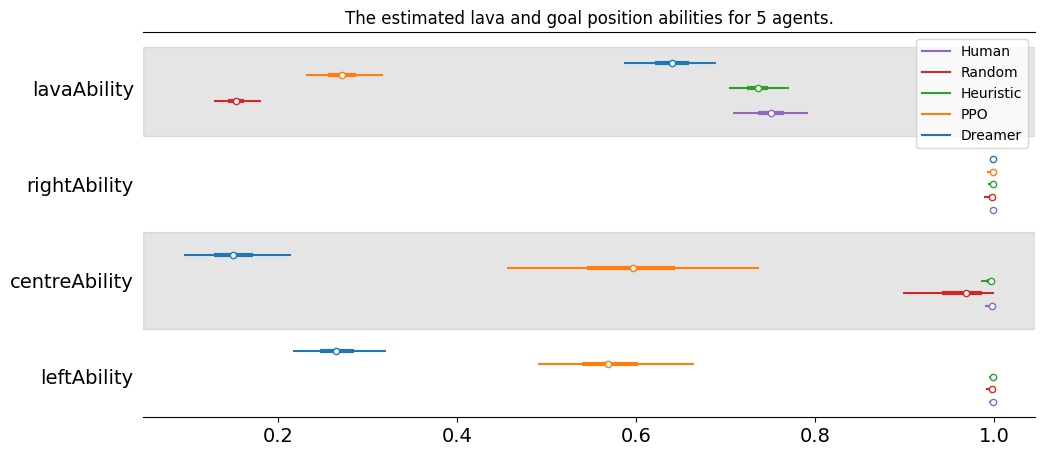

In [ ]:
ax = az.plot_forest(
    [idata_dreamer, idata_ppo, idata_heuristic, idata_random, idata_human],
    model_names=["Dreamer", "PPO", "Heuristic", "Random", "Human"],
    var_names=["lavaAbility", "rightAbility", "centreAbility", "leftAbility"],
    figsize=(11.5, 5),
    combined = True,
)
ax[0].set_title("The estimated lava and goal position abilities for 5 agents.")
plt.show()

And the summaries:

In [ ]:
summary_dreamer = az.summary(idata_dreamer['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility', 'rightAbility', 'centreAbility', 'leftAbility']])
summary_dreamer

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
objPermAbility,40.946,8.545,24.141,56.197,0.237,0.167,1254.0,987.0,1.0
navAbility,579.256,93.048,426.656,763.790,2.936,2.142,1129.0,878.0,1.0
lavaAbility,0.641,0.028,0.586,0.689,0.001,0.000,2055.0,1670.0,1.0
visualAcuityAbility,71.817,1.710,68.612,73.538,0.034,0.024,1477.0,945.0,1.0
rightAbility,0.999,0.001,0.997,1.000,0.000,0.000,1933.0,1106.0,1.0
centreAbility,0.152,0.033,0.095,0.215,0.001,0.001,2001.0,1139.0,1.0
leftAbility,0.266,0.028,0.216,0.321,0.001,0.000,2607.0,1584.0,1.0


In [ ]:
summary_ppo = az.summary(idata_ppo['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility', 'rightAbility', 'centreAbility', 'leftAbility']])
summary_ppo

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
objPermAbility,9.604,7.196,0.024,22.624,0.228,0.161,923.0,1027.0,1.00
navAbility,337.680,42.750,261.241,420.732,1.457,1.031,858.0,1092.0,1.01
lavaAbility,0.272,0.023,0.231,0.317,0.001,0.000,1108.0,1311.0,1.00
visualAcuityAbility,69.818,3.527,63.441,73.526,0.076,0.054,1364.0,1032.0,1.00
rightAbility,0.997,0.003,0.992,1.000,0.000,0.000,1429.0,778.0,1.00
centreAbility,0.596,0.075,0.456,0.738,0.002,0.002,1082.0,824.0,1.00
leftAbility,0.571,0.047,0.490,0.664,0.001,0.001,1565.0,1097.0,1.00


In [ ]:
summary_heuristic = az.summary(idata_heuristic['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility', 'rightAbility', 'centreAbility', 'leftAbility']])
summary_heuristic

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
objPermAbility,117.850,3.997,109.942,124.675,0.095,0.067,1766.0,1560.0,1.0
navAbility,1378.617,112.545,1179.345,1533.982,2.839,2.037,1107.0,551.0,1.0
lavaAbility,0.736,0.018,0.704,0.771,0.000,0.000,1737.0,1313.0,1.0
visualAcuityAbility,72.115,1.412,69.443,73.538,0.033,0.023,1125.0,781.0,1.0
rightAbility,0.998,0.002,0.994,1.000,0.000,0.000,1108.0,779.0,1.0
centreAbility,0.994,0.005,0.985,1.000,0.000,0.000,1221.0,572.0,1.0
leftAbility,0.998,0.002,0.994,1.000,0.000,0.000,1153.0,883.0,1.0


In [ ]:
summary_random = az.summary(idata_random['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility', 'rightAbility', 'centreAbility', 'leftAbility']])
summary_random

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
objPermAbility,144.259,19.192,109.212,181.138,0.629,0.445,933.0,1386.0,1.0
navAbility,158.744,30.450,102.504,213.347,1.009,0.713,905.0,1331.0,1.0
lavaAbility,0.153,0.014,0.128,0.180,0.000,0.000,1817.0,1352.0,1.0
visualAcuityAbility,71.051,2.411,66.513,73.536,0.049,0.035,1831.0,1376.0,1.0
rightAbility,0.996,0.004,0.989,1.000,0.000,0.000,1427.0,829.0,1.0
centreAbility,0.960,0.033,0.899,1.000,0.001,0.001,1632.0,1176.0,1.0
leftAbility,0.997,0.003,0.991,1.000,0.000,0.000,1614.0,892.0,1.0


In [ ]:
summary_human = az.summary(idata_human['posterior'][['objPermAbility', 'navAbility', 'lavaAbility', 'visualAcuityAbility', 'rightAbility', 'centreAbility', 'leftAbility']])
summary_human

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
objPermAbility,622.314,22.135,581.113,663.571,0.583,0.415,1462.0,1300.0,1.0
navAbility,841.422,40.029,768.735,914.311,1.196,0.854,1183.0,1128.0,1.0
lavaAbility,0.751,0.022,0.709,0.792,0.001,0.000,1311.0,1427.0,1.0
visualAcuityAbility,19.167,0.031,19.113,19.196,0.001,0.001,1032.0,746.0,1.0
rightAbility,0.998,0.002,0.995,1.000,0.000,0.000,1159.0,722.0,1.0
centreAbility,0.996,0.004,0.990,1.000,0.000,0.000,1129.0,724.0,1.0
leftAbility,0.998,0.002,0.994,1.000,0.000,0.000,1464.0,728.0,1.0


# BONUS EXERCISES

If there is time at the end:

1. Try running some diagnostics on the fitted models:

In [ ]:
az.plot_trace(idata['posterior'][['objPermAbility']])
az.plot_energy(idata)
az.summary(idata['posterior'][['objPermAbility', 'navAbility', 'visualAcuityAbility']])

2. Play around with the models to try to improve their fit and predictiveness.
3. Try increasing the number of tuning draws, the number of sample draws, and the number of chains, to improve convergence.
4. Play with different implementations of the logistic function to see if this effects fit or predictiveness.
5. Experiment with different relations between the capabilities (compensatory, non-compensatory) - can a (weighted) generalised mean be implemented to have more control over these relations?
6. Build a large multi-level measurement layout for running inferences on multiple agents simultaneously. A place to start for implementing this would be [here](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html).

*The dataset is copyrighted (All rights reserved, Konstantinos Voudouris 2024 (c)) and is only available for download on February 20th 2024 during the lab forum at AAAI-24 in Vancouver*